# Model Explainability and Regulation using SHAP and LIME

**Author:** Machine Learning Lab  
**Topic:** Explainability and Interpretability in Machine Learning  
**Focus:** SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations)

## 1. Introduction to Model Interpretability

In the realm of machine learning, the predictive power of complex models often comes at the cost of transparency. As models become more sophisticated—transitioning from simple linear regression to deep neural networks and ensemble methods—their decision-making processes can become opaque, creating what is commonly referred to as a **"black box" model**. This lack of transparency poses significant challenges, particularly in high-stakes domains such as healthcare, finance, criminal justice, and autonomous systems.

### Why Interpretability Matters

Model interpretability, or explainability, refers to the ability to understand and explain the predictions made by a machine learning model in a way that is comprehensible to humans. This capability is crucial for several reasons:

**Building Trust:** When stakeholders can understand why a model makes a particular decision, they are more likely to trust its predictions. In medical diagnosis, for example, a doctor needs to understand why an AI system recommends a specific treatment before acting on that recommendation.

**Ensuring Fairness:** Interpretability methods enable us to identify and mitigate biases in our models. Without the ability to examine how features influence predictions, we risk perpetuating or amplifying existing societal biases. For instance, a lending model might unfairly discriminate against certain demographic groups if we cannot inspect its decision-making process.

**Improving Robustness:** By understanding how a model works internally, we can identify its weaknesses and make it more robust to adversarial attacks and unexpected inputs. This is particularly important in security-critical applications.

**Complying with Regulations:** Legal frameworks increasingly mandate explainability. The European Union's General Data Protection Regulation (GDPR) includes a "right to explanation," which requires that individuals be able to obtain meaningful information about the logic involved in automated decisions that significantly affect them. Similarly, regulations in finance (such as fair lending laws) and healthcare (FDA requirements for medical devices) emphasize the importance of model transparency.

### Types of Interpretability

Interpretability can be categorized along two dimensions:

**Global vs. Local Interpretability:**
- **Global interpretability** provides an understanding of the model's behavior across the entire feature space. It answers questions like "Which features are most important overall?"
- **Local interpretability** explains individual predictions. It answers "Why did the model make this specific prediction for this particular instance?"

**Model-specific vs. Model-agnostic Methods:**
- **Model-specific** methods work only with particular types of models (e.g., examining coefficients in linear regression)
- **Model-agnostic** methods can be applied to any model, treating it as a black box

In this lab, we will focus on two powerful **model-agnostic** techniques that provide both local and global interpretability: **SHAP** and **LIME**.

## 2. Setup and Installation

Before we begin, we need to install the necessary Python libraries. Run the following command in your terminal or in a code cell:

In [2]:
!uv pip install pandas scikit-learn matplotlib numpy shap lime

Using Python 3.12.11 environment at: /Users/tarekatwan/Repos/MyWork/Teach/repos/adv_ml_ds/dev1
Audited 6 packages in 7ms


Now, let's import all the libraries we will be using throughout this notebook:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# SHAP and LIME
import shap
import lime
import lime.lime_tabular

# Initialize SHAP for notebook visualization
shap.initjs()

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 3. Dataset Selection and Preparation

For this lab, we will work with two real-world datasets from `sklearn.datasets`. Using real datasets instead of synthetic data provides more meaningful insights and better prepares you for practical applications.

### Dataset 1: California Housing (Regression)

The **California Housing dataset** contains information from the 1990 California census. The goal is to predict the median house value for California districts based on features such as median income, house age, average rooms, and location. This is a regression problem where we predict a continuous value.

**Features:**
- MedInc: Median income in block group
- HouseAge: Median house age in block group
- AveRooms: Average number of rooms per household
- AveBedrms: Average number of bedrooms per household
- Population: Block group population
- AveOccup: Average number of household members
- Latitude: Block group latitude
- Longitude: Block group longitude

### Dataset 2: Breast Cancer Wisconsin (Classification)

The **Breast Cancer Wisconsin dataset** contains features computed from digitized images of fine needle aspirates of breast masses. The goal is to predict whether a tumor is malignant or benign. This is a binary classification problem with significant real-world implications for medical diagnosis.

**Features:** 30 numerical features describing characteristics of cell nuclei (mean radius, mean texture, mean perimeter, etc.)

In [4]:
# Load the California Housing dataset for regression
housing = fetch_california_housing()
X_housing = pd.DataFrame(housing.data, columns=housing.feature_names)
y_housing = housing.target

print("California Housing Dataset:")
print(f"  Shape: {X_housing.shape}")
print(f"  Features: {list(X_housing.columns)}")
print(f"  Target range: [{y_housing.min():.2f}, {y_housing.max():.2f}]")
print()

# Load the Breast Cancer dataset for classification
cancer = load_breast_cancer()
X_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_cancer = cancer.target

print("Breast Cancer Wisconsin Dataset:")
print(f"  Shape: {X_cancer.shape}")
print(f"  Classes: {cancer.target_names}")
print(f"  Class distribution: {np.bincount(y_cancer)}")
print()

# Split both datasets into training and testing sets
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42
)

print("Train/Test Split:")
print(f"  Housing: {X_housing_train.shape[0]} train, {X_housing_test.shape[0]} test")
print(f"  Cancer: {X_cancer_train.shape[0]} train, {X_cancer_test.shape[0]} test")

California Housing Dataset:
  Shape: (20640, 8)
  Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
  Target range: [0.15, 5.00]

Breast Cancer Wisconsin Dataset:
  Shape: (569, 30)
  Classes: ['malignant' 'benign']
  Class distribution: [212 357]

Train/Test Split:
  Housing: 16512 train, 4128 test
  Cancer: 455 train, 114 test


## 4. Model Training

We will train **Random Forest** models for both tasks. Random Forests are ensemble methods that combine multiple decision trees to create powerful, non-linear models. While individual decision trees are interpretable, Random Forests with hundreds of trees become complex "black boxes," making them ideal candidates for explainability techniques.

### Why Random Forests?

Random Forests are excellent for this lab because they:
- Achieve high predictive performance
- Capture complex, non-linear relationships
- Are widely used in industry
- Represent the type of "black box" model that requires explainability tools

In [5]:
# Train a Random Forest Regressor on the California Housing dataset
print("Training Random Forest Regressor...")
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_regressor.fit(X_housing_train, y_housing_train)

# Evaluate the regressor
y_housing_pred = rf_regressor.predict(X_housing_test)
rmse_housing = np.sqrt(mean_squared_error(y_housing_test, y_housing_pred))
print(f"  RMSE: {rmse_housing:.4f}")
print()

# Train a Random Forest Classifier on the Breast Cancer dataset
print("Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_cancer_train, y_cancer_train)

# Evaluate the classifier
y_cancer_pred = rf_classifier.predict(X_cancer_test)
acc_cancer = accuracy_score(y_cancer_test, y_cancer_pred)
print(f"  Accuracy: {acc_cancer:.4f}")
print()
print("Classification Report:")
print(classification_report(y_cancer_test, y_cancer_pred, target_names=cancer.target_names))

Training Random Forest Regressor...
  RMSE: 0.5057

Training Random Forest Classifier...
  Accuracy: 0.9649

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.93      0.95        43
      benign       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



## 5. SHAP (SHapley Additive exPlanations)

### 5.1 Introduction to SHAP

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting predictions based on **Shapley values** from cooperative game theory. Developed by Lloyd Shapley (who won the Nobel Prize in Economics for this work), Shapley values provide a principled way to distribute a "payout" among players based on their contributions to a coalition.

### The Game Theory Connection

In the context of machine learning:
- The **"game"** is the prediction task
- The **"players"** are the input features
- The **"payout"** is the model's prediction
- The **"contribution"** of each player is how much each feature contributes to the prediction

### Key Properties of SHAP Values

SHAP values have several desirable mathematical properties:

1. **Local Accuracy:** The sum of SHAP values equals the difference between the model's prediction and the expected value (baseline)
2. **Consistency:** If a model changes so that a feature's contribution increases, its SHAP value should not decrease
3. **Missingness:** Features that don't affect the prediction have zero SHAP value

### Interpreting SHAP Values

A SHAP value for a feature represents:
- **Magnitude:** How much the feature contributes to the prediction
- **Direction:** Whether the feature pushes the prediction higher (positive) or lower (negative)
- **Baseline:** All contributions are measured relative to the expected value of the model output

For example, if the expected house price is \$200,000 and a specific house is predicted at \$250,000, SHAP values might show that high median income (+\$60,000) and good location (+\$20,000) increase the price, while old age (-\$30,000) decreases it.

### 5.2 SHAP for Regression (California Housing)

Let's start by explaining the predictions of our Random Forest Regressor. We'll use SHAP's `TreeExplainer`, which is optimized for tree-based models and provides exact Shapley values efficiently.

In [7]:
# Create a SHAP explainer for the Random Forest Regressor
# Note: We use a subset of test data for faster computation
print("Creating SHAP explainer for regression model...")
explainer_reg = shap.TreeExplainer(rf_regressor)

# Compute SHAP values for a subset of test data (for speed)
X_housing_test_sample = X_housing_test.iloc[:100]
shap_values_reg = explainer_reg.shap_values(X_housing_test_sample)


Creating SHAP explainer for regression model...


In [10]:
print(f"✓ SHAP values computed for {X_housing_test_sample.shape[0]} instances")
print(f"  Expected value (baseline): {explainer_reg.expected_value}")
print(f"  SHAP values shape: {shap_values_reg.shape}")

✓ SHAP values computed for 100 instances
  Expected value (baseline): [2.07306869]
  SHAP values shape: (100, 8)


#### 5.2.1 Global Feature Importance

The **summary plot** shows the distribution of SHAP values for each feature across all instances. Features are ranked by importance (mean absolute SHAP value).

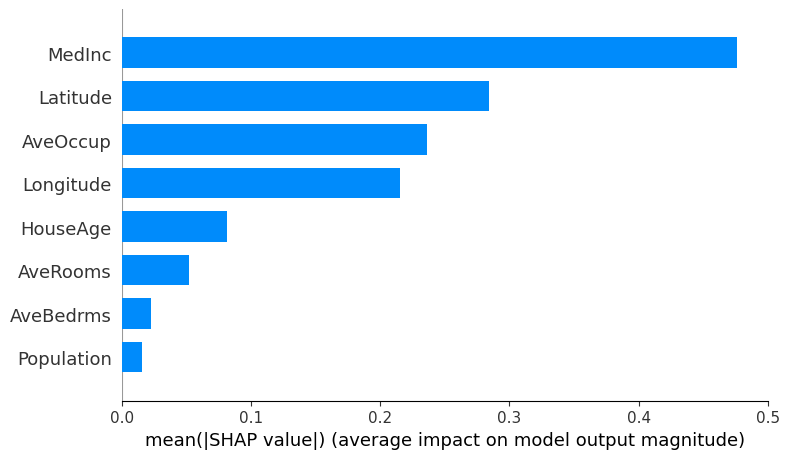

In [11]:
# Summary plot (bar) - shows average impact of each feature
shap.summary_plot(shap_values_reg, X_housing_test_sample, plot_type="bar")

#### 5.2.2 Feature Impact Distribution

The **beeswarm plot** (or dot plot) shows not just importance, but also:
- The distribution of impacts (spread of dots)
- The direction of effects (positive/negative)
- Feature values (color: red = high, blue = low)

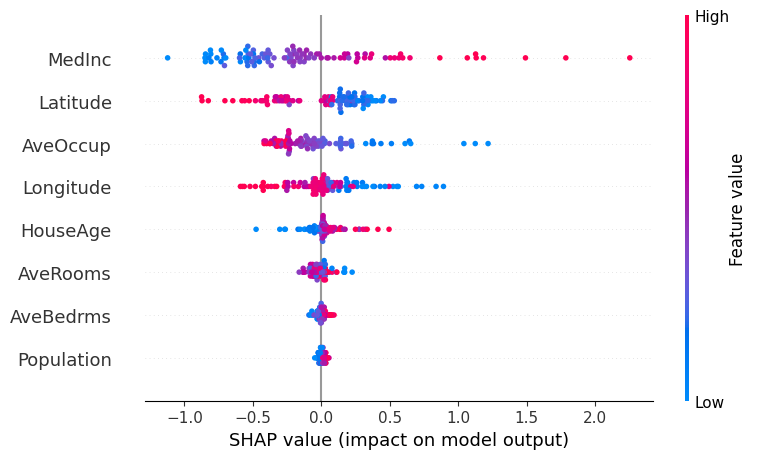

In [12]:
# Summary plot (dot) - shows distribution of SHAP values
shap.summary_plot(shap_values_reg, X_housing_test_sample)

#### 5.2.3 Individual Prediction Explanation (Waterfall Plot)

The **waterfall plot** explains a single prediction by showing how each feature pushes the prediction from the baseline (expected value) to the final prediction.

In [16]:
y_housing_test

array([0.477  , 0.458  , 5.00001, ..., 5.00001, 0.723  , 1.515  ],
      shape=(4128,))

Explaining instance 0:
  Actual value: 0.477
  Predicted value: 0.5087099999999998



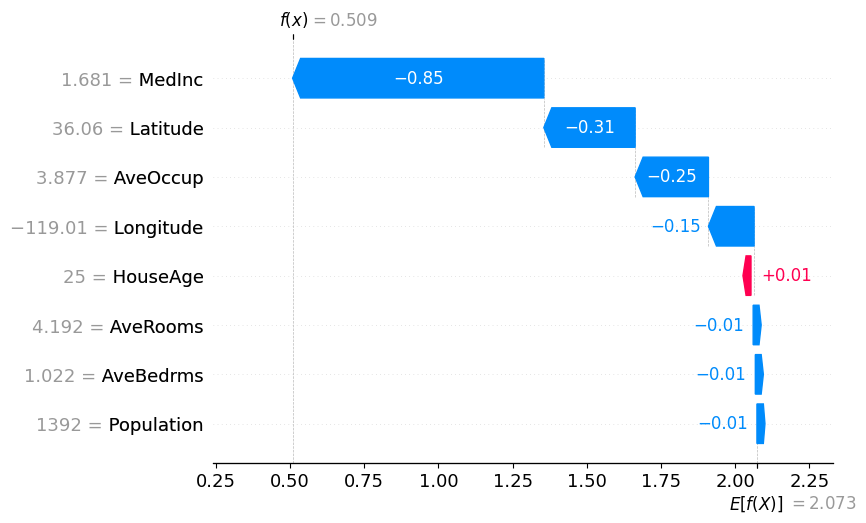

In [20]:
# Explain a single prediction with waterfall plot
instance_idx = 0
print(f"Explaining instance {instance_idx}:")
print(f"  Actual value: {y_housing_test[instance_idx]}")
print(f"  Predicted value: {rf_regressor.predict(X_housing_test_sample.iloc[[instance_idx]])[0]}")
print()

shap.plots.waterfall(shap.Explanation(
    values=shap_values_reg[instance_idx],
    base_values=explainer_reg.expected_value,
    data=X_housing_test_sample.iloc[instance_idx],
    feature_names=X_housing_test_sample.columns.tolist()
))

#### 5.2.4 Dependence Plots

**Dependence plots** show how a single feature affects predictions across its range of values. They can also reveal interactions between features.

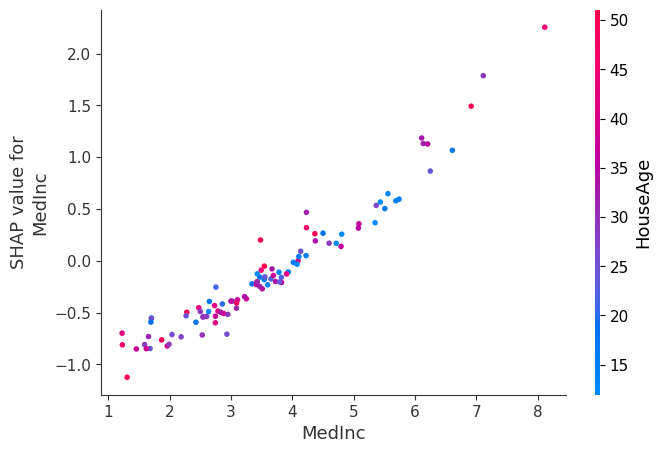

In [17]:
# Dependence plot for MedInc (median income)
shap.dependence_plot("MedInc", shap_values_reg, X_housing_test_sample)

### 5.3 SHAP for Classification (Breast Cancer)

For classification problems, SHAP values explain the log-odds (or probability) of each class. Let's apply SHAP to our breast cancer classifier.

In [26]:
# Create a SHAP explainer for the Random Forest Classifier
print("Creating SHAP explainer for classification model...")
explainer_clf = shap.TreeExplainer(rf_classifier)

# Compute SHAP values for a subset of test data
X_cancer_test_sample = X_cancer_test.iloc[:50]
shap_values_clf = explainer_clf.shap_values(X_cancer_test_sample)

print(f"✓ SHAP values computed for {X_cancer_test_sample.shape[0]} instances")
print(f"  Shape: {shap_values_clf.shape}")
print(f"  Expected values: {explainer_clf.expected_value}")

Creating SHAP explainer for classification model...
✓ SHAP values computed for 50 instances
  Type of shap_values_clf: <class 'numpy.ndarray'>
  Shape of shap_values_clf: (50, 30, 2)
  Number of classes: 50
  Expected values: [0.36793407 0.63206593]


#### 5.3.1 Global Feature Importance for Malignant Class

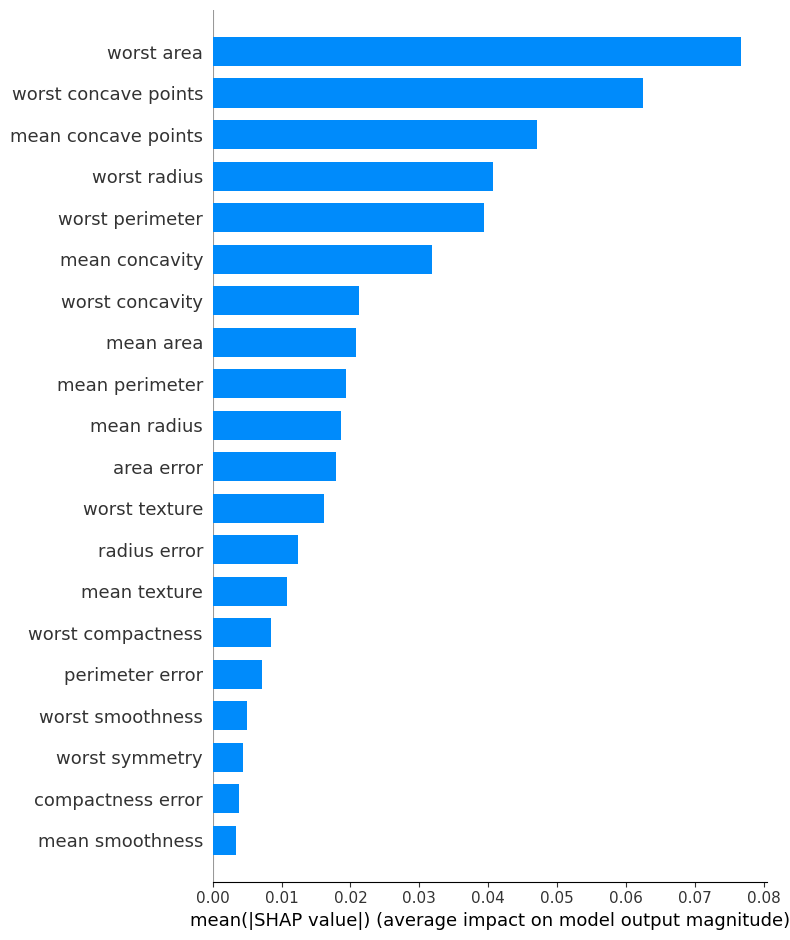

In [27]:
# Summary plot for class 1 (malignant)
# Note: shap_values_clf is a 3D array (n_samples, n_features, n_classes)
shap.summary_plot(shap_values_clf[:, :, 1], X_cancer_test_sample, plot_type="bar")

#### 5.3.2 Feature Impact Distribution for Malignant Class

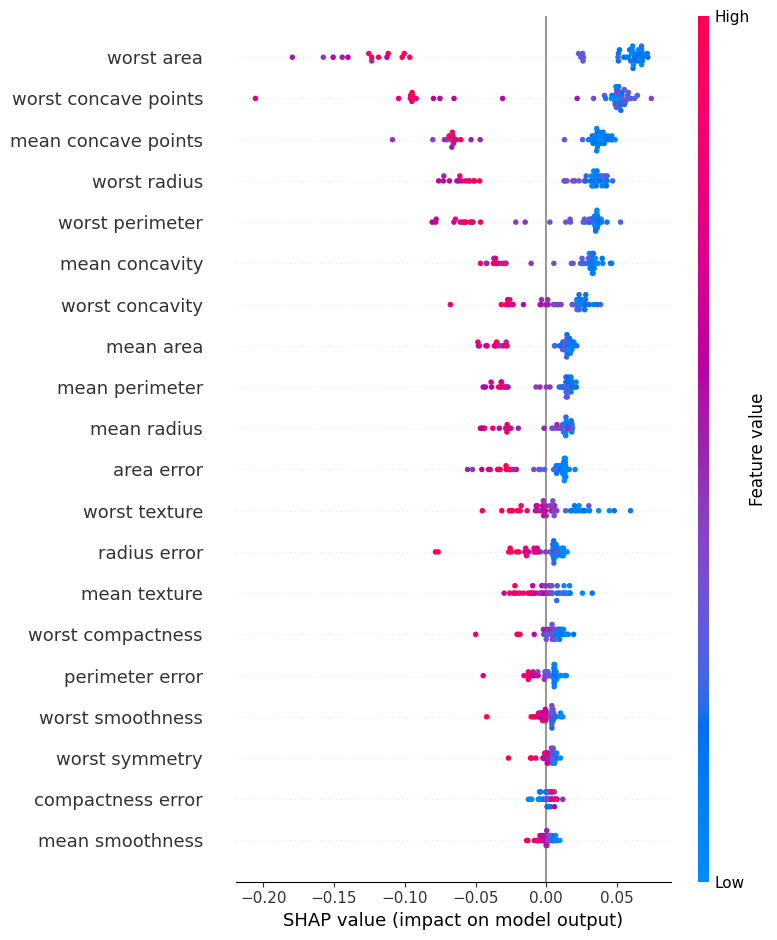

In [31]:
# Beeswarm plot for class 1 (malignant)
shap.summary_plot(shap_values_clf[:, :, 1], X_cancer_test_sample)

#### 5.3.3 Individual Prediction Explanation

Explaining instance 0:
  Actual class: benign
  Predicted class: benign
  Predicted probabilities: [0.03 0.97]



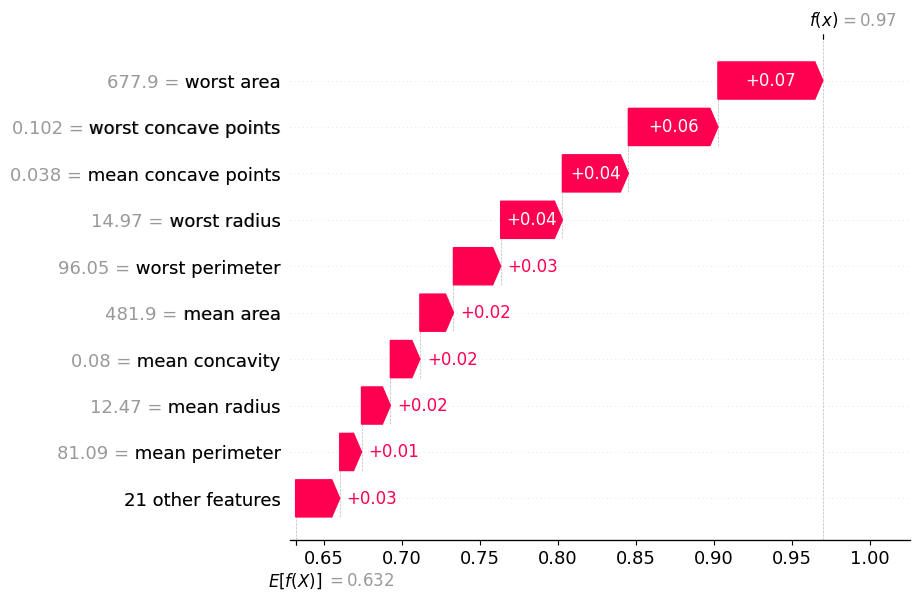

In [32]:
# Explain a single prediction
instance_idx = 0
print(f"Explaining instance {instance_idx}:")
print(f"  Actual class: {cancer.target_names[y_cancer_test[instance_idx]]}")
print(f"  Predicted class: {cancer.target_names[rf_classifier.predict(X_cancer_test_sample.iloc[[instance_idx]])[0]]}")
print(f"  Predicted probabilities: {rf_classifier.predict_proba(X_cancer_test_sample.iloc[[instance_idx]])[0]}")
print()

shap.plots.waterfall(shap.Explanation(
    values=shap_values_clf[instance_idx, :, 1],
    base_values=explainer_clf.expected_value[1],
    data=X_cancer_test_sample.iloc[instance_idx],
    feature_names=X_cancer_test_sample.columns.tolist()
))

## 6. LIME (Local Interpretable Model-agnostic Explanations)

### 6.1 Introduction to LIME

LIME (Local Interpretable Model-agnostic Explanations) takes a different approach to explainability compared to SHAP. Instead of using game theory, LIME explains predictions by approximating the complex model with a simple, interpretable model **locally** around the prediction of interest.

### How LIME Works

The LIME algorithm follows these steps:

1. **Select an instance** to explain
2. **Generate perturbed samples** around that instance
3. **Get predictions** from the black-box model for these perturbed samples
4. **Weight the samples** by their proximity to the original instance
5. **Train a simple model** (e.g., linear regression) on the weighted samples
6. **Extract feature weights** from the simple model as the explanation

### Key Characteristics of LIME

**Local Fidelity:** LIME prioritizes being accurate locally (around the instance being explained) rather than globally. The simple model may not represent the black-box model well everywhere, but it should be faithful in the neighborhood of the explained instance.

**Model-Agnostic:** LIME treats the model as a black box, requiring only the ability to query it for predictions. This makes it applicable to any model type.

**Interpretable Representations:** For tabular data, LIME can discretize continuous features into bins (e.g., "age > 30") to make explanations more human-friendly.

### LIME vs SHAP

While both provide local explanations, they differ in:
- **Theoretical foundation:** SHAP uses game theory, LIME uses local approximation
- **Consistency:** SHAP guarantees certain mathematical properties, LIME does not
- **Speed:** LIME can be faster for individual explanations, especially for non-tree models
- **Stability:** SHAP tends to be more stable across multiple runs

### 6.2 LIME for Classification (Breast Cancer)

Let's use LIME to explain predictions from our breast cancer classifier. LIME requires training data to understand feature distributions and to generate realistic perturbations.

In [33]:
# Create a LIME explainer for the Random Forest Classifier
print("Creating LIME explainer for classification model...")
explainer_lime_clf = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_cancer_train.values,
    feature_names=X_cancer_train.columns.tolist(),
    class_names=cancer.target_names.tolist(),
    mode='classification',
    discretize_continuous=True,  # Discretize features for more interpretable explanations
    random_state=42
)

print("✓ LIME explainer created successfully")

Creating LIME explainer for classification model...
✓ LIME explainer created successfully


#### 6.2.1 Explaining Individual Predictions

Let's explain a specific prediction and compare it with the SHAP explanation.

In [42]:
# Explain a single instance
instance_idx = 0
instance = X_cancer_test.iloc[instance_idx].values

print(f"Explaining instance {instance_idx}:")
print(f"  Actual class: {cancer.target_names[y_cancer_test[instance_idx]]}")
print(f"  Predicted class: {cancer.target_names[rf_classifier.predict([instance])[0]]}")
print(f"  Predicted probabilities: {rf_classifier.predict_proba([instance])[0]}")
print()

# Generate LIME explanation
exp_lime_clf = explainer_lime_clf.explain_instance(
    data_row=instance,
    predict_fn=rf_classifier.predict_proba,
    num_features=10,  # Show top 10 features
    top_labels=2  # Explain both classes
)

# Show the explanation as text (alternative to show_in_notebook)
print("LIME Explanation for Malignant Class:")
for feature, weight in exp_lime_clf.as_list(label=1):
    print(f"  {feature}: {weight:.4f}")
print()

print("LIME Explanation for Benign Class:")
for feature, weight in exp_lime_clf.as_list(label=0):
    print(f"  {feature}: {weight:.4f}")
print()

Explaining instance 0:
  Actual class: benign
  Predicted class: benign
  Predicted probabilities: [0.03 0.97]

LIME Explanation for Malignant Class:
  516.45 < worst area <= 686.60: 0.0757
  84.25 < worst perimeter <= 97.67: 0.0532
  13.05 < worst radius <= 14.97: 0.0343
  0.06 < mean concavity <= 0.13: -0.0187
  21.05 < worst texture <= 25.22: 0.0180
  16.17 < mean texture <= 18.68: 0.0135
  11.71 < mean radius <= 13.30: 0.0134
  75.10 < mean perimeter <= 85.98: 0.0124
  0.10 < worst concave points <= 0.16: 0.0118
  0.01 < compactness error <= 0.02: 0.0111

LIME Explanation for Benign Class:
  516.45 < worst area <= 686.60: -0.0757
  84.25 < worst perimeter <= 97.67: -0.0532
  13.05 < worst radius <= 14.97: -0.0343
  0.06 < mean concavity <= 0.13: 0.0187
  21.05 < worst texture <= 25.22: -0.0180
  16.17 < mean texture <= 18.68: -0.0135
  11.71 < mean radius <= 13.30: -0.0134
  75.10 < mean perimeter <= 85.98: -0.0124
  0.10 < worst concave points <= 0.16: -0.0118
  0.01 < compactness

#### 6.2.2 Visualizing LIME Explanation as a Plot

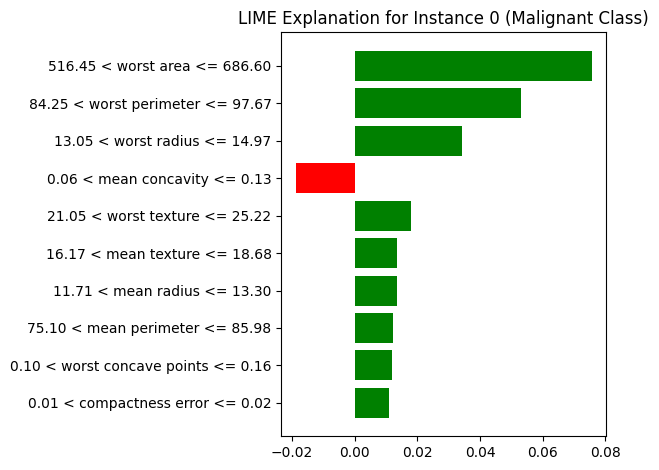

In [44]:
# Alternative visualization using matplotlib
fig = exp_lime_clf.as_pyplot_figure(label=1)  # label=1 for malignant class
plt.title(f"LIME Explanation for Instance {instance_idx} (Malignant Class)")
plt.tight_layout()
plt.show()

### 6.3 LIME for Regression (California Housing)

LIME can also be used for regression problems. Let's explain a house price prediction.

In [46]:
# Create a LIME explainer for the Random Forest Regressor
print("Creating LIME explainer for regression model...")
explainer_lime_reg = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_housing_train.values,
    feature_names=X_housing_train.columns.tolist(),
    mode='regression',
    discretize_continuous=True,
    random_state=42
)

print("✓ LIME explainer created successfully")

Creating LIME explainer for regression model...
✓ LIME explainer created successfully


In [47]:
# Explain a single instance
instance_idx = 0
instance = X_housing_test.iloc[instance_idx].values

print(f"Explaining instance {instance_idx}:")
print(f"  Actual value: {y_housing_test[instance_idx]:.4f}")
print(f"  Predicted value: {rf_regressor.predict([instance])[0]:.4f}")
print()

# Generate LIME explanation
exp_lime_reg = explainer_lime_reg.explain_instance(
    data_row=instance,
    predict_fn=rf_regressor.predict,
    num_features=8  # Show all 8 features
)

# Show the explanation as text
print("LIME Explanation for House Price Prediction:")
for feature, weight in exp_lime_reg.as_list():
    print(f"  {feature}: {weight:.4f}")
print()

Explaining instance 0:
  Actual value: 0.4770
  Predicted value: 0.5087

LIME Explanation for House Price Prediction:
  MedInc <= 2.57: -0.8883
  AveOccup > 3.28: -0.3956
  34.26 < Latitude <= 37.72: -0.2886
  -121.81 < Longitude <= -118.51: 0.1344
  1.01 < AveBedrms <= 1.05: -0.0475
  AveRooms <= 4.45: -0.0364
  18.00 < HouseAge <= 29.00: -0.0247
  1167.00 < Population <= 1726.00: -0.0147



## 7. SHAP vs. LIME: A Comprehensive Comparison

Now that we've explored both SHAP and LIME, let's compare them systematically:

| Aspect | SHAP | LIME |
|--------|------|------|
| **Theoretical Foundation** | Game Theory (Shapley Values) | Local Linear Approximation |
| **Consistency Guarantee** | Yes (satisfies desirable axioms) | No (can be inconsistent) |
| **Global Interpretability** | Yes (can aggregate local explanations) | Limited (primarily local) |
| **Local Interpretability** | Yes | Yes |
| **Model-Agnostic** | Yes | Yes |
| **Computational Speed** | Can be slow for complex models | Generally faster for individual predictions |
| **Stability** | More stable across runs | Can vary between runs |
| **Output Format** | SHAP values (additive contributions) | Feature weights in local linear model |
| **Feature Interactions** | Captures interactions implicitly | Limited interaction modeling |
| **Best Use Cases** | When consistency and theoretical guarantees matter | When speed and simplicity are priorities |

### When to Use SHAP

Choose SHAP when you need:
- **Theoretical guarantees** and consistency
- **Global feature importance** in addition to local explanations
- **Reliable, stable explanations** across multiple runs
- **Tree-based models** (TreeExplainer is very efficient)
- **Regulatory compliance** where mathematical rigor is important

### When to Use LIME

Choose LIME when you need:
- **Fast explanations** for individual predictions
- **Simple, intuitive explanations** for non-technical stakeholders
- **Flexibility** in defining custom distance metrics or perturbation strategies
- **Explanations for any model type** where SHAP might be slow
- **Discretized feature representations** for easier interpretation

### 7.1 Side-by-Side Comparison on the Same Instance

Let's compare SHAP and LIME explanations for the same prediction to see how they differ.

In [48]:
# Compare SHAP and LIME for the same instance
instance_idx = 0

print("=" * 70)
print(f"Comparing SHAP and LIME for Cancer Classification Instance {instance_idx}")
print("=" * 70)
print(f"Actual class: {cancer.target_names[y_cancer_test[instance_idx]]}")
print(f"Predicted class: {cancer.target_names[rf_classifier.predict(X_cancer_test.iloc[[instance_idx]])[0]]}")
print(f"Predicted probabilities: {rf_classifier.predict_proba(X_cancer_test.iloc[[instance_idx]])[0]}")
print()

# SHAP explanation
print("SHAP Top 5 Features (for malignant class):")
shap_values_instance = shap_values_clf[instance_idx, :, 1]
feature_names = X_cancer_test_sample.columns.tolist()
shap_importance = sorted(zip(feature_names, shap_values_instance), key=lambda x: abs(x[1]), reverse=True)[:5]
for feat, val in shap_importance:
    print(f"  {feat:30s}: {val:+.4f}")
print()

# LIME explanation
print("LIME Top 5 Features (for malignant class):")
lime_exp = exp_lime_clf.as_list(label=1)[:5]
for feat, val in lime_exp:
    print(f"  {feat:30s}: {val:+.4f}")
print()

print("Observations:")
print("- Both methods identify similar important features")
print("- SHAP values are additive and sum to the difference from baseline")
print("- LIME provides discretized feature conditions for easier interpretation")
print("- The magnitude of values differs due to different scales/interpretations")

Comparing SHAP and LIME for Cancer Classification Instance 0
Actual class: benign
Predicted class: benign
Predicted probabilities: [0.03 0.97]

SHAP Top 5 Features (for malignant class):
  worst area                    : +0.0672
  worst concave points          : +0.0574
  mean concave points           : +0.0423
  worst radius                  : +0.0396
  worst perimeter               : +0.0303

LIME Top 5 Features (for malignant class):
  516.45 < worst area <= 686.60 : +0.0757
  84.25 < worst perimeter <= 97.67: +0.0532
  13.05 < worst radius <= 14.97 : +0.0343
  0.06 < mean concavity <= 0.13 : -0.0187
  21.05 < worst texture <= 25.22: +0.0180

Observations:
- Both methods identify similar important features
- SHAP values are additive and sum to the difference from baseline
- LIME provides discretized feature conditions for easier interpretation
- The magnitude of values differs due to different scales/interpretations


## 8. Regulatory and Ethical Considerations

Model explainability is not merely a technical challenge; it is a fundamental requirement for responsible AI deployment. As machine learning systems increasingly influence critical decisions affecting human lives, the ability to explain these decisions becomes both an ethical imperative and a legal necessity.

### Regulatory Landscape

**General Data Protection Regulation (GDPR):** The European Union's GDPR includes provisions for a "right to explanation" in Article 22, which addresses automated decision-making. While the exact interpretation is debated, organizations must be able to provide meaningful information about the logic involved in automated decisions that significantly affect individuals.

**Fair Lending Regulations:** In the United States, financial institutions must comply with fair lending laws such as the Equal Credit Opportunity Act (ECOA) and the Fair Credit Reporting Act (FCRA). These regulations require lenders to provide adverse action notices explaining why credit was denied, making model explainability essential for compliance.

**Healthcare and FDA Requirements:** Medical devices and clinical decision support systems that use AI must demonstrate not only efficacy but also interpretability. The FDA increasingly requires explainability for AI-based medical devices to ensure patient safety and enable clinical validation.

**Algorithmic Accountability:** Various jurisdictions are considering or have enacted algorithmic accountability laws that require organizations to assess and explain automated decision systems, particularly in high-stakes domains like employment, housing, and criminal justice.

### Ethical Imperatives

Beyond legal compliance, explainability serves several ethical purposes:

**Fairness and Non-Discrimination:** Explainability tools like SHAP and LIME enable practitioners to identify when models rely on protected attributes (directly or through proxies) or exhibit disparate impact across demographic groups. By examining feature contributions, we can detect and mitigate bias before deployment.

**Transparency and Trust:** Stakeholders—whether patients, loan applicants, or criminal defendants—deserve to understand how decisions that affect them are made. Transparency builds trust and enables informed consent.

**Accountability:** When models make errors or cause harm, explainability enables us to understand what went wrong and assign responsibility appropriately. Without explainability, accountability becomes impossible.

**Human Agency:** Explainable AI preserves human agency by enabling people to contest, appeal, or understand automated decisions. This is particularly important in domains where automated systems augment rather than replace human judgment.

### Best Practices for Model Documentation

Organizations deploying machine learning systems should:

1. **Document model development:** Maintain records of data sources, feature engineering, model selection, and validation procedures
2. **Conduct fairness audits:** Regularly assess models for disparate impact across protected groups
3. **Implement explanation systems:** Integrate tools like SHAP and LIME into production systems to provide explanations on demand
4. **Establish governance processes:** Create review boards and approval processes for high-stakes AI applications
5. **Train stakeholders:** Ensure that both technical teams and end-users understand how to interpret explanations
6. **Monitor in production:** Continuously monitor model behavior and explanations in production to detect drift or emerging issues

### Limitations and Challenges

While explainability techniques like SHAP and LIME are powerful, they have limitations:

- **Explanation fidelity:** Local explanations may not fully capture complex model behavior
- **Cognitive load:** Detailed explanations can overwhelm non-expert users
- **Gaming:** Explanations could potentially be manipulated or gamed
- **Trade-offs:** There may be tensions between accuracy, explainability, and other objectives

Practitioners must balance these considerations thoughtfully, recognizing that explainability is necessary but not sufficient for responsible AI.

## 9. Hands-on Exercises

Now it's your turn to practice! Complete the following exercises to deepen your understanding of SHAP and LIME.

### Exercise 1: Explore Different Instances with SHAP

Choose three different instances from the breast cancer test set:
- One correctly classified as benign
- One correctly classified as malignant
- One misclassified instance

For each instance:
1. Generate a SHAP waterfall plot
2. Identify the top 3 features contributing to the prediction
3. Explain in your own words why the model made that prediction

**Hint:** Use `rf_classifier.predict()` and compare with `y_cancer_test` to find misclassified instances.

### Exercise 2: Compare SHAP and LIME Explanations

For the same instance from Exercise 1 (the misclassified one):
1. Generate both SHAP and LIME explanations
2. Compare the top 5 features identified by each method
3. Discuss: Do they agree? If not, why might they differ?
4. Which explanation do you find more useful, and why?

### Exercise 3: Feature Interactions with SHAP

Using the California Housing dataset:
1. Create a SHAP dependence plot for the "Latitude" feature
2. Observe if there are any interaction effects (indicated by color patterns)
3. Create a dependence plot for "Longitude" as well
4. Discuss: How do location features (Latitude and Longitude) interact to affect house prices?

### Exercise 4: Train a Different Model and Explain It

Train a Gradient Boosting Classifier on the breast cancer dataset:
```python
from sklearn.ensemble import GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_cancer_train, y_cancer_train)
```

Then:
1. Use SHAP to explain predictions from this new model
2. Compare the feature importance rankings with the Random Forest model
3. Discuss: Are the explanations consistent? What does this tell you about the two models?

### Exercise 5: Bias Detection

Imagine the California Housing dataset includes a sensitive attribute (e.g., a proxy for race or ethnicity). 
1. Use SHAP to examine if the model relies heavily on location features (Latitude/Longitude)
2. Discuss: Could this lead to discriminatory outcomes? How?
3. Propose: What steps could you take to mitigate this issue?

**Note:** This is a thought exercise. The actual dataset doesn't include demographic information, but location can serve as a proxy.

In [ ]:
# Your code for exercises goes here



## 10. Summary and Key Takeaways

In this lab, we have explored two powerful techniques for model explainability: SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations). Through hands-on examples with real-world datasets, we have learned how to use these tools to understand the predictions of complex, black-box machine learning models.

### Key Concepts Covered

**Model Interpretability:** We examined why explainability matters for trust, fairness, robustness, and regulatory compliance. The distinction between global and local interpretability, as well as model-specific versus model-agnostic approaches, provides a framework for thinking about explanation methods.

**SHAP:** Grounded in game theory, SHAP provides consistent, theoretically sound explanations with desirable mathematical properties. SHAP values are additive, meaning they sum to the difference between the prediction and the baseline. SHAP excels at both local explanations (waterfall plots, force plots) and global understanding (summary plots, dependence plots).

**LIME:** Based on local linear approximation, LIME explains predictions by fitting simple models around specific instances. While LIME lacks the theoretical guarantees of SHAP, it offers speed and flexibility, making it practical for quick explanations and non-technical audiences.

**Regulatory and Ethical Considerations:** Explainability is not just a technical tool but a requirement for responsible AI. Regulations like GDPR, fair lending laws, and healthcare requirements mandate transparency. Beyond compliance, explainability serves ethical imperatives around fairness, accountability, and human agency.

### Practical Recommendations

When deploying machine learning systems in practice:

- **Use SHAP for tree-based models** where TreeExplainer provides fast, exact computations
- **Use LIME for quick, intuitive explanations** when interacting with non-technical stakeholders
- **Combine multiple explanation methods** to gain different perspectives on model behavior
- **Integrate explainability into your workflow** from development through production monitoring
- **Document your models thoroughly** including data sources, features, and explanation methodologies
- **Conduct regular fairness audits** using explainability tools to detect and mitigate bias

### Further Learning

To deepen your understanding of model explainability:

- **Read the original papers:** Lundberg & Lee (2017) for SHAP, Ribeiro et al. (2016) for LIME
- **Explore the SHAP documentation:** https://shap.readthedocs.io/
- **Study Christoph Molnar's book:** "Interpretable Machine Learning" (available free online)
- **Experiment with other techniques:** Integrated Gradients, Anchors, Counterfactual Explanations
- **Stay current:** The field of explainable AI is rapidly evolving with new methods and best practices

By mastering explainability techniques like SHAP and LIME, you are equipped to build more transparent, trustworthy, and accountable AI systems that benefit society while respecting individual rights and dignity.